In [1]:
%matplotlib inline
import cobra
import libsbml
model = cobra.io.read_sbml_model("PlantCoreMetabolism_v2_0_0.xml")
model.solver="glpk"

In [2]:
def generateMultiphaseLeafModel(model,number_of_phases=12,
                                met2accumulate=["STARCH_p","MAL_v","aMAL_v","CIT_v","aCIT_v", "SUCROSE_v",
                                                "PHOSPHO_ENOL_PYRUVATE_c","PYRUVATE_c","ADP_D_GLUCOSE_p",
                                                "FRUCTOSE_6P_p","GLC_1_P_c","GLC_6_P_c","GLYCEROL_3P_c","CIS_ACONITATE_c"],
                                verbose=False):
    # Generate a multiphase model with 12 copies of core model
    from cobra.core import Model, Reaction, Metabolite
    ModelF = Model("Final")
    ModelF.solver="glpk"
    for i in range(1,number_of_phases+1):
        model1 = model.copy()
        model1.reactions
        for rxn in model1.reactions:
            rxn.id = rxn.id + str(i)
        model1.metabolites
        for met in model1.metabolites:
            met.id = met.id + str(i)
        ModelF = ModelF + model1

        setMet1 = set()
        for met in model1.metabolites:
            setMet1.add(met.id)
        setMet2 = set()
        for met in ModelF.metabolites:
            setMet2.add(met.id)
        if verbose:
            print("What's in model1 but not in ModelF")
            print(str(setMet1 - setMet2))

        for met in setMet1 - setMet2:
            met = model1.metabolites.get_by_id(met)
            metCopy = met.copy()
            ModelF.add_metabolites([metCopy])
    
    # Add linker reactions to connect the different model phases together
    from cobra.core import Reaction
    for met in met2accumulate:
        for i in range(1,number_of_phases+1):
            rxn = Reaction(met+str(i)+"_accumulation")
            if i != number_of_phases:
                #reference metabolite from phase 1
                met1 = ModelF.metabolites.get_by_id(met+str(i))
                #reference metabolite from phase 2
                met2 = ModelF.metabolites.get_by_id(met+str(i+1))
                #add met1 and met2 to reaction such that one is consumed and other is produced
            else:
                #reference metabolite from phase 1
                met1 = ModelF.metabolites.get_by_id(met+str(i))
                #reference metabolite from phase 2
                met2 = ModelF.metabolites.get_by_id(met+str(1))
                #add met1 and met2 to reaction such that one is consumed and other is produced
            rxn.add_metabolites({met1:-1, met2:1})
            rxn.lower_bound = 0
            #check reaction is correct
            if verbose:
                print(rxn.reaction)
            #add reaction to model
            ModelF.add_reactions([rxn])
    
    #turn off al sugar uptake
    for phase in range(1,13):
        ModelF.reactions.get_by_id("Sucrose_tx"+str(phase)).lower_bound = 0
        ModelF.reactions.get_by_id("Sucrose_tx"+str(phase)).upper_bound = 0
        ModelF.reactions.get_by_id("GLC_tx"+str(phase)).lower_bound = 0
        ModelF.reactions.get_by_id("GLC_tx"+str(phase)).upper_bound = 0
    
    #making sure no other reaction is set as objective
    for rxn in ModelF.reactions:
        rxn.objective_coefficient = 0
    
    #add reaction to drain day and night phloem from the metabolic system in 3:1 ratio and set that as the objective of the system
    PhlRxn = Reaction("Diel_phloem_export")
    PhlRxn.lower_bound = 0
    PhlRxn.upper_bound = 1000
    ModelF.add_reactions([PhlRxn])
    PhlRxn.objective_coefficient = 1

    #assuming 12h daylenght
    sunset = 6

    #introduce metabolite to represent night-time phloem
    for i in range(1,13):
        met1 = Metabolite("Phloem_e"+str(i))
        rxn = ModelF.reactions.get_by_id("Phloem_output_tx"+str(i))
        rxn.add_metabolites({met1:1})
        if i>sunset:
            PhlRxn.add_metabolites({met1:-0.25})
        else:
            PhlRxn.add_metabolites({met1:-0.75})
    
    return ModelF

In [3]:
# Generate a 12 phase leaf model with day:night phloem export constrained to 3:1
ModelF = generateMultiphaseLeafModel(model,number_of_phases=12,
                                     met2accumulate=["STARCH_p","MAL_v","aMAL_v","CIT_v","aCIT_v", "SUCROSE_v",
                                                     "PHOSPHO_ENOL_PYRUVATE_c","PYRUVATE_c","ADP_D_GLUCOSE_p",
                                                     "FRUCTOSE_6P_p","GLC_1_P_c","GLC_6_P_c","GLYCEROL_3P_c",
                                                     "CIS_ACONITATE_c","PROTON_v"],
                                     verbose=False)

In [4]:
#assuming 12h daylenght
sunset = 6


for i in range(1,13):
    #light availability
    rxnL = ModelF.reactions.get_by_id("Photon_tx"+str(i))
    if i>sunset:
        rxnL.upper_bound = 0
    else:
        rxnL.upper_bound = 100
    


In [5]:
PhaseII = 12,1
PhaseIII = 1,5
PhaseIV = 5,6
PhaseI = 6,12

for i in range(1,13):
    rxnC = ModelF.reactions.get_by_id("CO2_tx"+str(i))
    if i <= 1:
        print("This is phase II")
        rxnC.upper_bound = 1
        rxnC.lower_bound = 0
    elif i > 1 and i <=5:
        print("This is phase III")
        rxnC.upper_bound = 0
        rxnC.lower_bound = -1
    elif i > 5 and i<= 6:
        print("This is phase IV")
        rxnC.upper_bound = 1
        rxnC.lower_bound = 0
    elif i > 6:
        print("This is phase I")
        rxnC.upper_bound = 4
        rxnC.lower_bound = 0
        
from cobra import flux_analysis
sol = flux_analysis.parsimonious.pfba(ModelF)
print("CO2 exchange ="+str(rxnC.flux)+str(i))
print("Sucrose exported ="+str(ModelF.reactions.Diel_phloem_export.flux*0.73))   #Each mol of 'phloem' 

This is phase II
This is phase III
This is phase III
This is phase III
This is phase III
This is phase IV
This is phase I
This is phase I
This is phase I
This is phase I
This is phase I
This is phase I
CO2 exchange =4.012
Sucrose exported =0.313894634037855


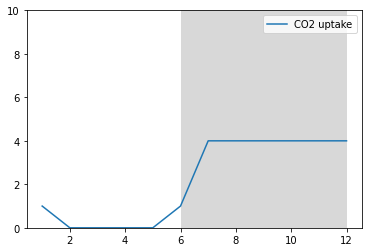

In [6]:
import matplotlib.pyplot as plt
xlist = range(1,13)
ylist = list()
for i in range(1,13):
    ylist.append(ModelF.reactions.get_by_id("CO2_tx"+str(i)).flux)
plt.plot(xlist,ylist,label="CO2 uptake")
plt.legend()
plt.ylim(0,10)
xlist = list(range(6,13))
plt.fill_between(xlist,65,facecolor='grey',alpha=0.3)

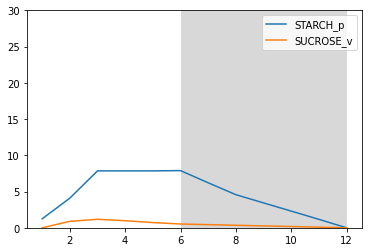

In [7]:
import matplotlib.pyplot as plt
met2accumulate = ["STARCH_p", "SUCROSE_v"]
for met in met2accumulate:
    xlist = range(1,13)
    ylist = list()
    for i in range(1,13):
        ylist.append(ModelF.reactions.get_by_id(met+str(i)+"_accumulation").flux)
    plt.plot(xlist,ylist,label=met)
plt.legend()
plt.ylim(0,30)
xlist = list(range(6,13))
plt.fill_between(xlist,65,facecolor='grey',alpha=0.3)

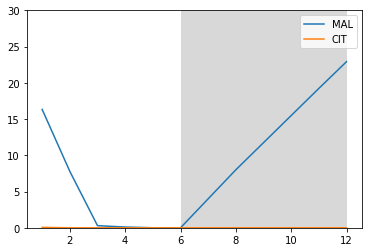

In [8]:
#import plot as plt
import matplotlib.pyplot as plt
xlist = range(1,13)
malate_list = list()
citrate_list= list()
for i in range(1,13):
    Mal1 = float(ModelF.reactions.get_by_id("MAL_v"+str(i)+"_accumulation").flux)
    Mal2 = float(ModelF.reactions.get_by_id("aMAL_v"+str(i)+"_accumulation").flux)
    malate = Mal1 + Mal2
    malate_list.append(malate)
    Cit1 = float(ModelF.reactions.get_by_id("CIT_v"+str(i)+"_accumulation").flux)
    Cit2 = float(ModelF.reactions.get_by_id("aCIT_v"+str(i)+"_accumulation").flux)
    citrate = Cit1 + Cit2
    citrate_list.append(citrate)
plt.plot(xlist,malate_list,label="MAL")
plt.plot(xlist,citrate_list,label="CIT")
plt.legend() 
plt.ylim(0,30)
xlist = list(range(6,13))
plt.fill_between(xlist,65,facecolor='grey',alpha=0.3)

In [9]:
import pandas as pd
df = pd.read_excel("ProcessedData_v2.xlsx")
df

,Hour,Tre6P average,Tre6P STDEV,ADPGlc average,ADPGlc STDEV,Glc1P average,Glc1P STDEV,Gly3P average,Gly3P STDEV,PEP average,...,Malate average,Malate STDEV,Starch average,Starch STDEV,Sucrose average,Sucrose STDEV,Glucose average,Glucose STDEV,Fructose average,Fructose STDEV
0,8,0.001039,0.000173,0.000020,0.000011,0.001275,0.000038,0.001340,0.000287,0.001178,...,22.166805,3.463563,1.461434,0.505262,1.461200,0.161808,0.541709,0.199194,0.600596,0.207339
1,10,0.001247,0.000139,0.000144,0.000030,0.001081,0.000170,0.001572,0.000294,0.006269,...,21.127736,1.731782,4.114814,0.533051,2.055092,0.344292,0.683694,0.098903,0.804047,0.122369
2,12,0.001385,0.000208,0.000142,0.000044,0.001285,0.000236,0.001469,0.000433,0.006338,...,12.815184,1.731782,7.850993,0.764798,1.804937,0.229795,0.747123,0.188208,0.861981,0.238679
3,14,0.001247,0.000139,0.000100,0.000032,0.002002,0.000256,0.002248,0.000627,0.005715,...,7.619839,1.731782,9.670342,0.795652,1.576992,0.221025,0.689183,0.197879,0.794865,0.251481
4,16,0.000866,0.000104,0.000096,0.000029,0.002362,0.000177,0.003831,0.000409,0.001074,...,3.809920,1.039069,15.360978,2.574658,1.915472,0.253486,0.550505,0.214743,0.634426,0.265527
5,18,0.000901,0.000104,0.000058,0.000019,0.002317,0.000190,0.004122,0.000887,0.002563,...,2.424494,1.039069,16.499896,3.534045,1.949733,0.379399,0.713453,0.164099,0.843065,0.230244
6,20,0.000658,0.000139,0.000024,0.000010,0.001337,0.000156,0.003135,0.000641,0.000901,...,2.770851,0.692713,15.348692,2.658746,1.868774,0.249467,0.881410,0.241654,1.041523,0.283570
7,22,0.000727,0.000035,0.000021,0.000022,0.001884,0.000121,0.002130,0.000845,0.000623,...,10.044334,2.424494,12.498887,2.064579,1.915619,0.343639,0.645096,0.289476,0.584370,0.245597
8,0,0.000727,0.000069,0.000014,0.000007,0.001860,0.000246,0.001146,0.000229,0.000520,...,13.161541,1.385425,10.133589,0.801612,1.524218,0.303094,0.810213,0.112538,0.820344,0.142881
9,2,0.000797,0.000035,0.000018,0.000012,0.001863,0.000246,0.001153,0.000152,0.000450,...,19.395955,1.731782,6.878455,0.910757,1.438945,0.344106,0.856619,0.255323,1.021498,0.294428


In [10]:
keyDict = {'2-OG':["2_KETOGLUTARATE_c",],
 '3-PGA':["",],
 'ADPGlc':["ADP_D_GLUCOSE_p",],
 'Citrate':["CIT_v","aCIT_v"],
 'Fru6P':["FRUCTOSE_6P_p",],
 'Glc1P':["GLC_1_P_c",],
 'Glc6P':["GLC_6_P_c",],
 'Gly3P':["GLYCEROL_3P_c",],
 'Iso-citrate':["THREO_DS_ISO_CITRATE_c"],
 'Malate':["MAL_v","aMAL_v"],
 'Man6P':["",],
 'PEP':["PHOSPHO_ENOL_PYRUVATE_c",],
 'Pyruvate':["PYRUVATE_c",],
 'Tre6P':["",],
 'aconitate':["CIS_ACONITATE_c",],
 'Starch':["STARCH_p"],
 'Sucrose': ["SUCROSE_v"]}

In [11]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("PHOSPHO_ENOL_PYRUVATE_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["PEP average"][7:])
        rxn.lower_bound = min(df["PEP average"][7:])
    else:
        rxn.upper_bound = max(df["PEP average"][:7])
        rxn.lower_bound = min(df["PEP average"][:7])

from cobra import flux_analysis
sol = flux_analysis.parsimonious.pfba(ModelF)
backup_ModelF = ModelF.copy()

In [12]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("PYRUVATE_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Pyruvate average"][7:])
        rxn.lower_bound = min(df["Pyruvate average"][7:])
    else:
        rxn.upper_bound = max(df["Pyruvate average"][:7])
        rxn.lower_bound = min(df["Pyruvate average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [13]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("GLC_6_P_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Glc6P average"][7:])
        rxn.lower_bound = min(df["Glc6P average"][7:])
    else:
        rxn.upper_bound = max(df["Glc6P average"][:7])
        rxn.lower_bound = min(df["Glc6P average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [14]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("STARCH_p"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Starch average"][7:])
        rxn.lower_bound = min(df["Starch average"][7:])
    else:
        rxn.upper_bound = max(df["Starch average"][:7])
        rxn.lower_bound = min(df["Starch average"][:7])
    

sol = flux_analysis.parsimonious.pfba(ModelF)

In [15]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("MAL_v"+str(i)+"_accumulation")
    if i>sunset:
        rxn.upper_bound = max(df["Malate average"][7:])*0.7
        rxn.lower_bound = min(df["Malate average"][7:])*0.7
    else:
        rxn.upper_bound = max(df["Malate average"][:7])*0.7
        rxn.lower_bound = min(df["Malate average"][:7])*0.7
    
    rxn = ModelF.reactions.get_by_id("aMAL_v"+str(i)+"_accumulation")
    if i>sunset:
        rxn.upper_bound = max(df["Malate average"][7:])*0.3
        rxn.lower_bound = min(df["Malate average"][7:])*0.3
    else:
        rxn.upper_bound = max(df["Malate average"][:7])*0.3
        rxn.lower_bound = min(df["Malate average"][:7])*0.3
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [16]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("SUCROSE_v"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Sucrose average"][7:])
        rxn.lower_bound = min(df["Sucrose average"][7:])
    else:
        rxn.upper_bound = max(df["Sucrose average"][:7])
        rxn.lower_bound = min(df["Sucrose average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [17]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("ADP_D_GLUCOSE_p"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["ADPGlc average"][7:])
        rxn.lower_bound = min(df["ADPGlc average"][7:])
    else:
        rxn.upper_bound = max(df["ADPGlc average"][:7])
        rxn.lower_bound = min(df["ADPGlc average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [18]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("FRUCTOSE_6P_p"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Fru6P average"][7:])
        rxn.lower_bound = min(df["Fru6P average"][7:])
    else:
        rxn.upper_bound = max(df["Fru6P average"][:7])
        rxn.lower_bound = min(df["Fru6P average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [19]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("GLC_1_P_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Glc1P average"][7:])
        rxn.lower_bound = min(df["Glc1P average"][7:])
    else:
        rxn.upper_bound = max(df["Glc1P average"][:7])
        rxn.lower_bound = min(df["Glc1P average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [20]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("GLYCEROL_3P_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["Gly3P average"][7:])
        rxn.lower_bound = min(df["Gly3P average"][7:])
    else:
        rxn.upper_bound = max(df["Gly3P average"][:7])
        rxn.lower_bound = min(df["Gly3P average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [21]:
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("CIS_ACONITATE_c"+str(i)+"_accumulation")

    if i>sunset:
        rxn.upper_bound = max(df["aconitate average"][7:])
        rxn.lower_bound = min(df["aconitate average"][7:])
    else:
        rxn.upper_bound = max(df["aconitate average"][:7])
        rxn.lower_bound = min(df["aconitate average"][:7])
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [22]:
#*0.5 since CIT has different charges (-3 and -2) due to the vacuolar pH (divide flux in 2)
sunset = 6

for i in range(1,13):
    rxn = ModelF.reactions.get_by_id("CIT_v"+str(i)+"_accumulation")
    if i>sunset:
        rxn.upper_bound = max(df["Citrate average"][7:])*0.5
        rxn.lower_bound = min(df["Citrate average"][7:])*0.5
    else:
        rxn.upper_bound = max(df["Citrate average"][:7])*0.5
        rxn.lower_bound = min(df["Citrate average"][:7])*0.5
    rxn = ModelF.reactions.get_by_id("aCIT_v"+str(i)+"_accumulation")
    if i>sunset:
        rxn.upper_bound = max(df["Citrate average"][7:])*0.5
        rxn.lower_bound = min(df["Citrate average"][7:])*0.5
    else:
        rxn.upper_bound = max(df["Citrate average"][:7])*0.5
        rxn.lower_bound = min(df["Citrate average"][:7])*0.5
        

sol = flux_analysis.parsimonious.pfba(ModelF)

In [23]:
data_mets = {'Malate':["MAL_v","aMAL_v","MAL_c","MAL_m","MAL_x","MAL_p"],
             'Citrate':["CIT_v","aCIT_v","CIT_c","CIT_m","CIT_x"],
             'ADPGlc':["ADP_D_GLUCOSE_p"],
             'Fru6P':["FRUCTOSE_6P_p","FRUCTOSE_6P_c"],
             'Glc1P':["GLC_1_P_c","GLC_1_P_p"],
             'Glc6P':["GLC_6_P_c","GLC_6_P_p"],
             'Gly3P':["GLYCEROL_3P_c",],
             'aconitate':["CIS_ACONITATE_c","CIS_ACONITATE_m"],
             'Sucrose':["SUCROSE_v","SUCROSE_c"],
             'Starch':["STARCH_p",],
             'PEP':["PHOSPHO_ENOL_PYRUVATE_p","PHOSPHO_ENOL_PYRUVATE_c"],
             'Pyruvate':["PYRUVATE_m","PYRUVATE_c","PYRUVATE_p"],
             'Glc6P':["GLC_6_P_c","GLC_6_P_p"]
            }

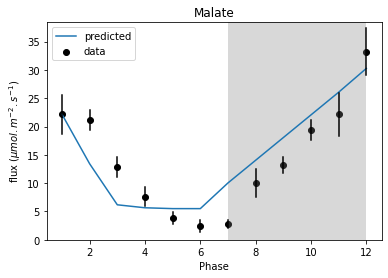

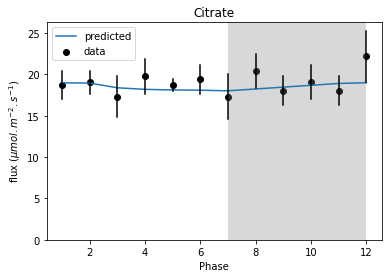

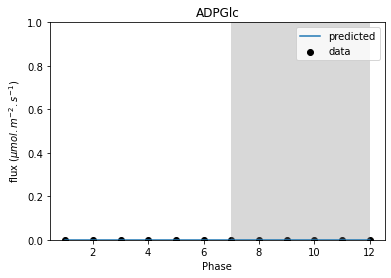

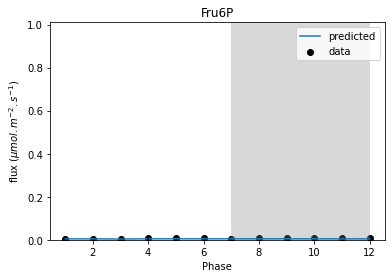

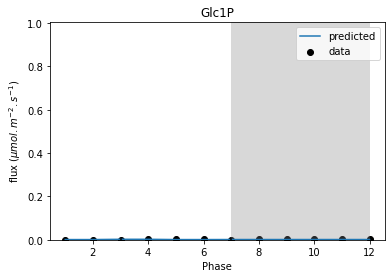

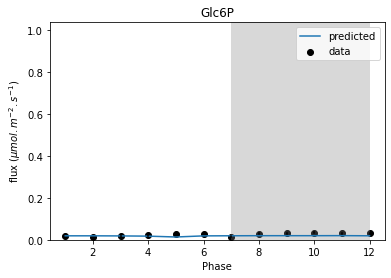

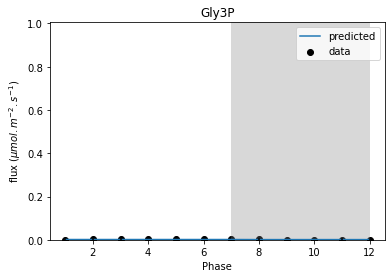

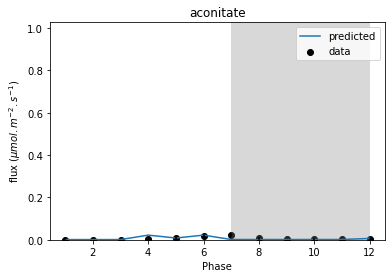

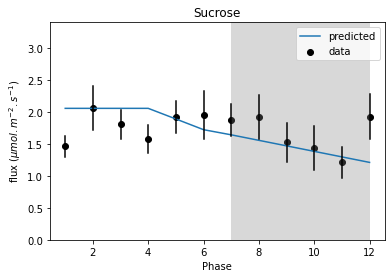

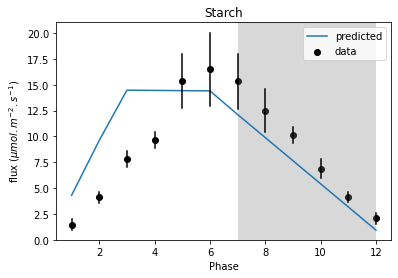

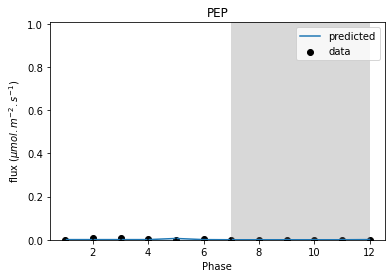

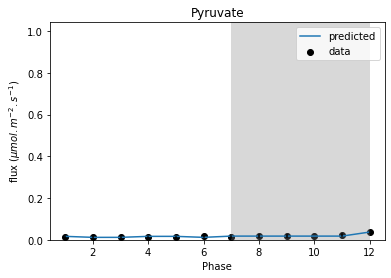

In [24]:
for met_id in data_mets.keys():
    xlist = range(1,13)
    pred_list = list()
    tot_list = list()
    data_list= list()
    error_max = list()
    error_min = list()
    met = met_id
    for i in range(1,13):
        tot = 0
        for rxn in keyDict[met]:
            rxn = rxn + str(i)+"_accumulation"
            tot = tot+float(sol.fluxes[rxn])
        val = float(list(df[df["Hour"]==((i*2)+6)%24][met+" average"])[0])
        data_list.append(val)
        pred_list.append(tot)
        stdev = float(list(df[df["Hour"]==((i*2)+6)%24][met+" STDEV"])[0])
        error_max.append(val+stdev)
        error_min.append(val-stdev)
    plt.plot(xlist,pred_list,label="predicted")
    plt.scatter(xlist,data_list,label="data",color="black")
    for i in range(0,len(xlist)):
        plt.plot([xlist[i],xlist[i]],[error_max[i],error_min[i]],color="black")
    plt.legend()
    plt.xlabel("Phase")
    plt.ylabel("flux ("+r'$ µmol.m^{-2}.s^{-1}$'+")")
    plt.fill_between(xlist[6:],65,facecolor='grey',alpha=0.3)
    plt.title(met)
    plt.ylim(0,max(max(pred_list),max(error_max))+1)
    plt.show()

In [25]:
constrained = dict()
for rxn in ModelF.reactions:
    if (rxn.upper_bound != 0 and rxn.upper_bound != 1000) or (rxn.lower_bound != 0 and rxn.lower_bound != -1000):
        constrained[rxn.id]={"ub":rxn.upper_bound,"lb":rxn.lower_bound}

In [26]:
for rxnID in sorted(constrained.keys()):
    print(rxnID)
    print(constrained[rxnID])

ADP_D_GLUCOSE_p10_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.4200609587143253e-05}
ADP_D_GLUCOSE_p11_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.4200609587143253e-05}
ADP_D_GLUCOSE_p12_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.4200609587143253e-05}
ADP_D_GLUCOSE_p1_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p2_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p3_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p4_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p5_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p6_accumulation
{'ub': 0.00014408423385979494, 'lb': 2.00886672208368e-05}
ADP_D_GLUCOSE_p7_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.4200609587143253e-05}
ADP_D_GLUCOSE_p8_accumulation
{'ub': 2.56303685231366e-05, 'lb': 1.4200609587143253e-05}
ADP_D_GLUCOSE_p9_a

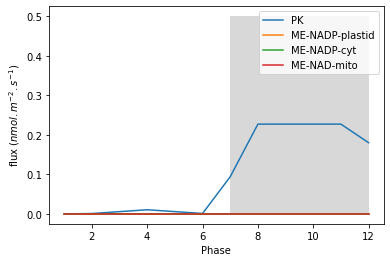

In [27]:
xlist = list()
ylist1 = list()
ylist2 = list()
ylist3 = list()
ylist4 = list()
for i in range(1,13):
    i1 = i
    if i != 12:
        i2 = i+1
    else:
        i2 = 1
    xlist.append(i)
    ylist1.append(sol["PEPDEPHOS_RXN_c"+str(i)])
    ylist2.append(sol["MALIC_NADP_RXN_p"+str(i)])
    ylist3.append(sol["MALIC_NADP_RXN_c"+str(i)])
    ylist4.append(sol["1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"+str(i)])
    

import matplotlib.pyplot as plt

plt.plot(xlist,ylist1,label="PK")
plt.plot(xlist,ylist2,label="ME-NADP-plastid")
plt.plot(xlist,ylist3,label="ME-NADP-cyt")
plt.plot(xlist,ylist4,label="ME-NAD-mito")
plt.fill_between(xlist[6:],0.5,facecolor='grey',alpha=0.3)
plt.legend()
plt.xlabel("Phase")
plt.ylabel("flux ("+r'$ nmol.m^{-2}.s^{-1}$'+")")
plt.show()

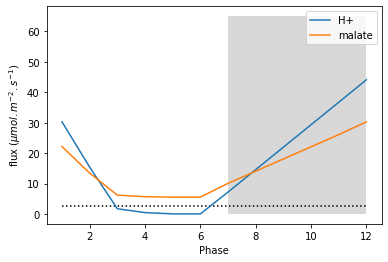

In [28]:
xlist = list()
ylist1 = list()
ylist2 = list()
ylist3 = list()
for i in range(1,13):
    i1 = i
    if i != 12:
        i2 = i+1
    else:
        i2 = 1
    xlist.append(i)
    ylist1.append(sol["PROTON_v"+str(i)+"_accumulation"])
    ylist2.append(sol["MAL_v"+str(i)+"_accumulation"]+sol["aMAL_v"+str(i)+"_accumulation"])
    ylist3.append(ylist1[i-1]/ylist2[i-1])
    

import matplotlib.pyplot as plt

plt.plot(xlist,ylist1,label="H+")
plt.plot(xlist,ylist2,label="malate")
plt.hlines(2.5,1,12,linestyles="dotted")
plt.fill_between(xlist[6:],65,facecolor='grey',alpha=0.3)
plt.legend()
plt.xlabel("Phase")
plt.ylabel("flux ("+r'$ µmol.m^{-2}.s^{-1}$'+")")
plt.show()

In [29]:
#assign fake compartment to metabolites not associated to any compartment and write ModelF to .xml
for met in ModelF.metabolites:
    if met.compartment=="" or met.compartment == None:
        met.compartment="f"
cobra.io.write_sbml_model(ModelF, "CAM_12PModel_v2_Stijn.xml")